In [2]:
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import EfficientNetB0
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from time import time

In [3]:
#   CARGA DE HDF5
# ==============================
# CARGA DIRECTA DE TRAIN/VAL
h5_train = h5py.File("train_128.h5", "r")
train_images = h5_train["images"]
train_labels = h5_train["labels"]

h5_val = h5py.File("val_128.h5", "r")
val_images = h5_val["images"]
val_labels = h5_val["labels"]

print("Train:", train_images.shape, "Val:", val_images.shape)

Train: (12372, 128, 128, 3) Val: (2651, 128, 128, 3)


In [4]:
# MIXED PRECISION
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [5]:
tipos_galaxia = {
    0: "spiral",
    1: "elliptical",
    2: "lenticular",
    3: "irregular",
    4: "merger",
    5: "unknown",
    6: "barred spiral",
    7: "compact",
    8: "edge-on",
    9: "uncertain"
} #el dataset no ofrece la equivalencia y las etiquetas solo son numeros, por eso recurrimos a la docuentación oficial del dataset para hacer la lista manualmente

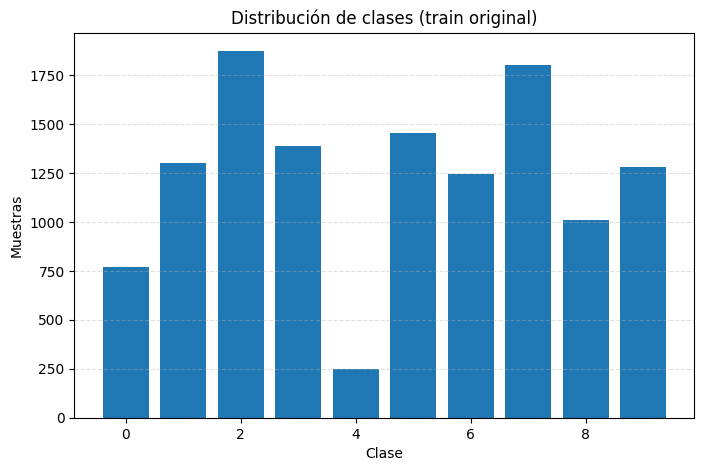

In [6]:
# DISTRIBUCIÓN ORIGINAL EN TRAIN
classes, counts = np.unique(train_labels, return_counts=True)
plt.figure(figsize=(8,5))
plt.bar(classes, counts)
plt.title("Distribución de clases (train original)")
plt.xlabel("Clase")
plt.ylabel("Muestras")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.show()

In [7]:
# BALANCEO OFFLINE (sobre índices de train)
unique_classes, counts = np.unique(train_labels, return_counts=True)

min_target = 1200
balanced_indices = []

for c, cnt in zip(unique_classes, counts):
    class_idx = np.where(train_labels[:] == c)[0]
    if cnt > min_target:
        sel = np.random.choice(class_idx, min_target, replace=False)
    else:
        sel = np.random.choice(class_idx, min_target, replace=True)
    balanced_indices.extend(sel)

balanced_indices = np.array(balanced_indices)
np.random.shuffle(balanced_indices)

print("Nuevo tamaño del train balanceado:", len(balanced_indices))

Nuevo tamaño del train balanceado: 12000


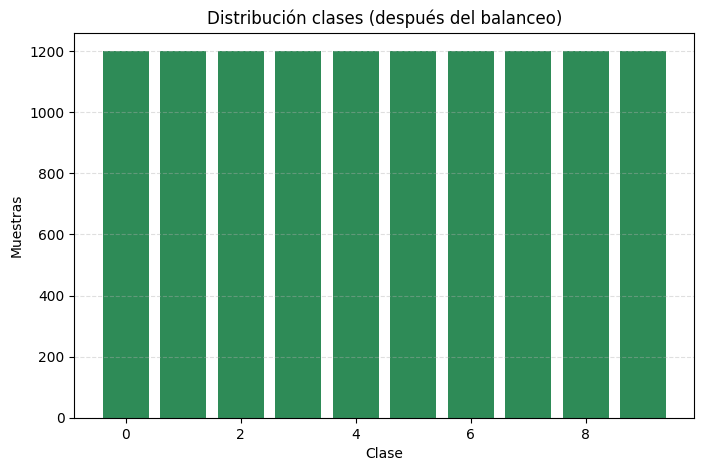

In [8]:
# DISTRIBUCIÓN TRAS BALANCEO
balanced_lbls = np.array([train_labels[i] for i in balanced_indices])
c2, cnt2 = np.unique(balanced_lbls, return_counts=True)

plt.figure(figsize=(8,5))
plt.bar(c2, cnt2, color="seagreen")
plt.title("Distribución clases (después del balanceo)")
plt.xlabel("Clase")
plt.ylabel("Muestras")
plt.grid(True, axis="y", linestyle="--", alpha=0.4)
plt.show()

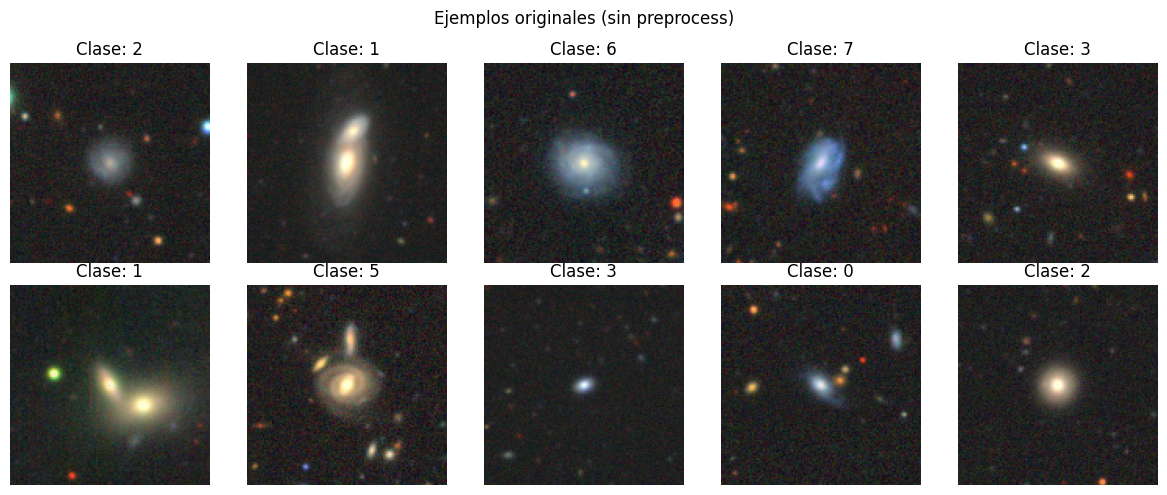

In [14]:
# Visualización directa desde HDF5 (sin preprocess)
idx = np.random.randint(0, len(train_images), 10)

plt.figure(figsize=(12,5))
for i, id_img in enumerate(idx):
    img = train_images[id_img]  # sin cast, sin preprocess
    lbl = train_labels[id_img]

    plt.subplot(2,5,i+1)
    plt.imshow(img)  # rango 0..255 correcto
    plt.title(f"Clase: {lbl}")
    plt.axis("off")

plt.suptitle("Ejemplos originales (sin preprocess)")
plt.tight_layout()
plt.show()

In [15]:
# PREPROCESADO Y DATASETS

from tensorflow.keras.applications.efficientnet import preprocess_input

IMG_SIZE = 128
batch_size = 64

def load_train(i):
    i = int(i)
    return train_images[i], train_labels[i]

def load_val(i):
    i = int(i)
    return val_images[i], val_labels[i]

def preprocess(i, mode="train"):
    if mode == "train":
        img, lbl = tf.py_function(load_train, [i], [tf.uint8, tf.int32])
    else:
        img, lbl = tf.py_function(load_val, [i], [tf.uint8, tf.int32])

    img.set_shape([IMG_SIZE, IMG_SIZE, 3])
    lbl.set_shape([])

    img = preprocess_input(tf.cast(img, tf.float32))
    return img, lbl

In [16]:
# Augment solo imágenes
aug_layers = tf.keras.Sequential([
    layers.RandomRotation(0.4),
    layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.15),
])

def augment(img, lbl):
    return aug_layers(img), lbl

In [17]:
#   CREACIÓN DE DATASETS con tf.data (solo imágenes)
def create_ds(indices, mode="train", aug=False):
    ds = tf.data.Dataset.from_tensor_slices(indices)
    ds = ds.shuffle(5000)
    ds = ds.map(lambda x: preprocess(x, mode), num_parallel_calls=tf.data.AUTOTUNE)
    if aug:
        ds = ds.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_ds(balanced_indices, mode="train", aug=True)
val_indices = np.arange(len(val_images))
val_ds = create_ds(val_indices, mode="val", aug=False)

In [18]:
#   MODELO EfficientNetB0 (solo imágenes)
img_input = Input(shape=(IMG_SIZE,IMG_SIZE,3))
base = EfficientNetB0(weights="imagenet", include_top=False, input_tensor=img_input)
base.trainable = False
for layer in base.layers[-100:]:
    layer.trainable = True

x = layers.GlobalAveragePooling2D()(base.output)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation="relu")(x)
out = layers.Dense(10, activation="softmax", dtype="float32")(x)

model = Model(inputs=img_input, outputs=out)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 128, 128,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 128, 128,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 128, 128,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 129, 129,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 64, 64,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 64, 64,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 64, 64,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 64, 64,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 64, 64,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 64, 64,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 64, 64,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 64, 64,    │        512 │ block1a_se_excit

 Total params: 4,419,309 (16.86 MB)

 Trainable params: 3,847,870 (14.68 MB)

 Non-trainable params: 571,439 (2.18 MB)

In [14]:
# ENTRENAMIENTO
from tensorflow.keras.callbacks import EarlyStopping

# Callbacks
early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,            
    restore_best_weights=True
)

lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

t0 = time()
history = model.fit(
    train_ds,
    epochs=40,
    validation_data=val_ds,
    callbacks=[early, lr_schedule]
)
print("Tiempo:", round(time()-t0,2), "seg")



Epoch 1/40
 33/188 ━━━━━━━━━━━━━━━━━━━━ 37:17 14s/step - accuracy: 0.0986 - loss: 2.4146

KeyboardInterrupt: 

In [ ]:
#   EVALUACIÓN EN TEST (Con carga de fichero H5)
h5_test = h5py.File("/content/test_128.h5", "r")
test_images = h5_test["images"]
test_labels = h5_test["labels"]

test_idx = np.arange(len(test_images))

def load_test(i):
    i = int(i)
    return test_images[i], test_labels[i]

def preprocess_test(i):
    img, lbl = tf.py_function(load_test, [i], [tf.uint8, tf.int32])
    img.set_shape([IMG_SIZE, IMG_SIZE, 3])
    lbl.set_shape([])
    img = preprocess_input(tf.cast(img, tf.float32))
    return img, lbl

test_ds = (tf.data.Dataset.from_tensor_slices(test_idx)
           .map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
           .batch(batch_size)
           .prefetch(tf.data.AUTOTUNE))

y_true, y_pred = [], []
for imgs, lbls in test_ds:
    preds = model.predict(imgs)
    y_true.extend(lbls.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

inverse_map = {v:k for k,v in tipos_galaxia.items()}
y_true_labels = [inverse_map[y] for y in y_true]
y_pred_labels = [inverse_map[y] for y in y_pred]

print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize="true")
plt.show()

In [ ]:
# CURVAS DE ENTRENAMIENTO
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.legend(); plt.title("Loss")
plt.show()

plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.legend(); plt.title("Accuracy")
plt.show()

In [ ]:
#   GUARDAR MODELO
model.save("/content/modelo_galaxias.keras")
model.save("/content/drive/MyDrive/modelo_galaxias.keras")